In [1]:
#Allows relative imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
#imports 
from src.preprocessing import *
from src.models import deepcat_cnn
from src.torch_util import *
from src.dataloader import *
from src.train_eval import *
%load_ext autoreload
%autoreload 2
#checking gpu status
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import BatchSampler, RandomSampler    
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import math

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using : {}".format(device))
else:
    device = torch.device('cpu')
    print("Using : {}".format(device))
    
RANGE = range(12,17)
TRAINDIR = '../TrainingData/'
files = os.listdir(TRAINDIR)
files.remove('readme.md')
#Reading data
train_normal = read_seq(TRAINDIR+files[0])
train_tumor = read_seq(TRAINDIR+files[2])

Using : cuda
TRAIN TENSORS torch.Size([7379, 1, 15, 12]) cpu
LABELS torch.Size([7379]) cpu


In [4]:
def reload():
    TRAIN_FEATURES, TRAIN_LABELS = generate_features_labels(train_tumor, train_normal, None)#device)
    print("TRAIN TENSORS",TRAIN_FEATURES[12].shape, TRAIN_FEATURES[12].device)
    print("LABELS", TRAIN_LABELS[12].shape, TRAIN_LABELS[12].device)
    
    #Loading models 
    model_dict = {}

    for length in RANGE:
        model = deepcat_cnn(length)
        model_dict[length]=model
        del model
    print(model_dict[12].dummy_param.device)
    return TRAIN_FEATURES, TRAIN_LABELS, model_dict

def shuffle_split(features, target, ratio):
    #shuffling
    indices = torch.randperm(features.size(0))
    data = features[indices]
    labels = target[indices]
    #splitting 
    z = math.ceil((1-ratio)* TRAIN_FEATURES[l].size(0))
    train_data = data[0:z]
    train_labels = labels[0:z]
    test_data = data[z:]
    test_labels = labels[z:]

    return train_data, train_labels, test_data, test_labels

def saveplot(l):
    f, a1 = plt.subplots(figsize=(10,7))
    a2 = a1.twinx()
    
    a1.plot(train_loss_dict[l], 'b-', lw =0.5, label='Train')#, ax=a)
    a2.plot(val_loss_dict[l], 'r-', lw = 0.5, label='Validation')#,ax=a)
    a1.legend(loc='best')
    a2.legend(loc='best')
    a1.set_title('Losses for L = {}'.format(l))
    plt.savefig('fig'+str(l)+'.jpg')
    plt.close(f)
    

In [5]:
from datetime import datetime
TRAIN_FEATURES, TRAIN_LABELS, model_dict = reload()
nb_epochs = 3000
criterion = nn.CrossEntropyLoss()
ratio = 1/4
mini_batch_size = 250

train_loss_dict = {}
val_loss_dict = {}

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)

for l in range(12,17):
    #splits:
    indices = torch.randperm(TRAIN_FEATURES[l].size(0))
    
    z = math.ceil((1-ratio)* TRAIN_FEATURES[l].size(0))
    
    model_dict[l].to(device)

    data_temp = TRAIN_FEATURES[l].detach().clone().to(device)
    labels_temp = TRAIN_LABELS[l].detach().clone().to(device)
    
    train_data, train_target, eval_data, eval_target = shuffle_split(data_temp,
                                                                     labels_temp,
                                                                     ratio)
    
    optimizer = optim.Adam(model_dict[l].parameters(), lr = 0.00125)
    print(model_dict[l].dummy_param.device, train_data.device, eval_target.device)
    train_losses = []
    val_losses = []
    print("\n######L=",l)
    print("TOTAL OF {} samples, {} in train and {} in val.".format(data_temp.size(0),
                                                                   train_data.size(0),
                                                                   eval_data.size(0)))

    for e in range(nb_epochs):

        train_loss = train_model(model_dict[l], criterion, optimizer, train_data, train_target, e, mini_batch_size)
        train_losses.append(train_loss)

        val_loss, _, _ = eval_model(model_dict[l], criterion, eval_data, eval_target)
        val_losses.append(val_loss)
        if e%150==0:print("\nEPOCHS =",e,"\ntrain:",train_loss,"\nVal:",val_loss)
            
    train_loss_dict[l]=train_losses
    val_loss_dict[l]=val_losses
    saveplot(l)
    model_dict[l].to('cpu')
    del TRAIN_FEATURES[l]
    del TRAIN_LABELS[l]
    
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

Start Time = 20:30:05
cuda:0 cuda:0 cuda:0

######L= 12
TOTAL OF 7379 samples, 5535 in train and 1844 in val.

EPOCHS = 0 
train: 0.0028204226881507937 
Val: 0.0003598063473070521

EPOCHS = 150 
train: 0.0021100784812624 
Val: 0.0002534854955114667

EPOCHS = 300 
train: 0.0019560491489524117 
Val: 0.00026329351415344535

EPOCHS = 450 
train: 0.0018869226756350027 
Val: 0.00027630059553589067

EPOCHS = 600 
train: 0.0019242387261601752 
Val: 0.00029686985460641326

EPOCHS = 750 
train: 0.0018511235337054933 
Val: 0.0003293836388308676

EPOCHS = 900 
train: 0.0018448137870864386 
Val: 0.000322752880688086

EPOCHS = 1050 
train: 0.001810682525264323 
Val: 0.0003615227606705109

EPOCHS = 1200 
train: 0.0017735133056933532 
Val: 0.00041194327999868

EPOCHS = 1350 
train: 0.0017616083628439968 
Val: 0.0004338520597222053

EPOCHS = 1500 
train: 0.001844338699838764 
Val: 0.00044386428245494786

EPOCHS = 1650 
train: 0.0017744522915299993 
Val: 0.0004812132510601052

EPOCHS = 1800 
train: 0.00

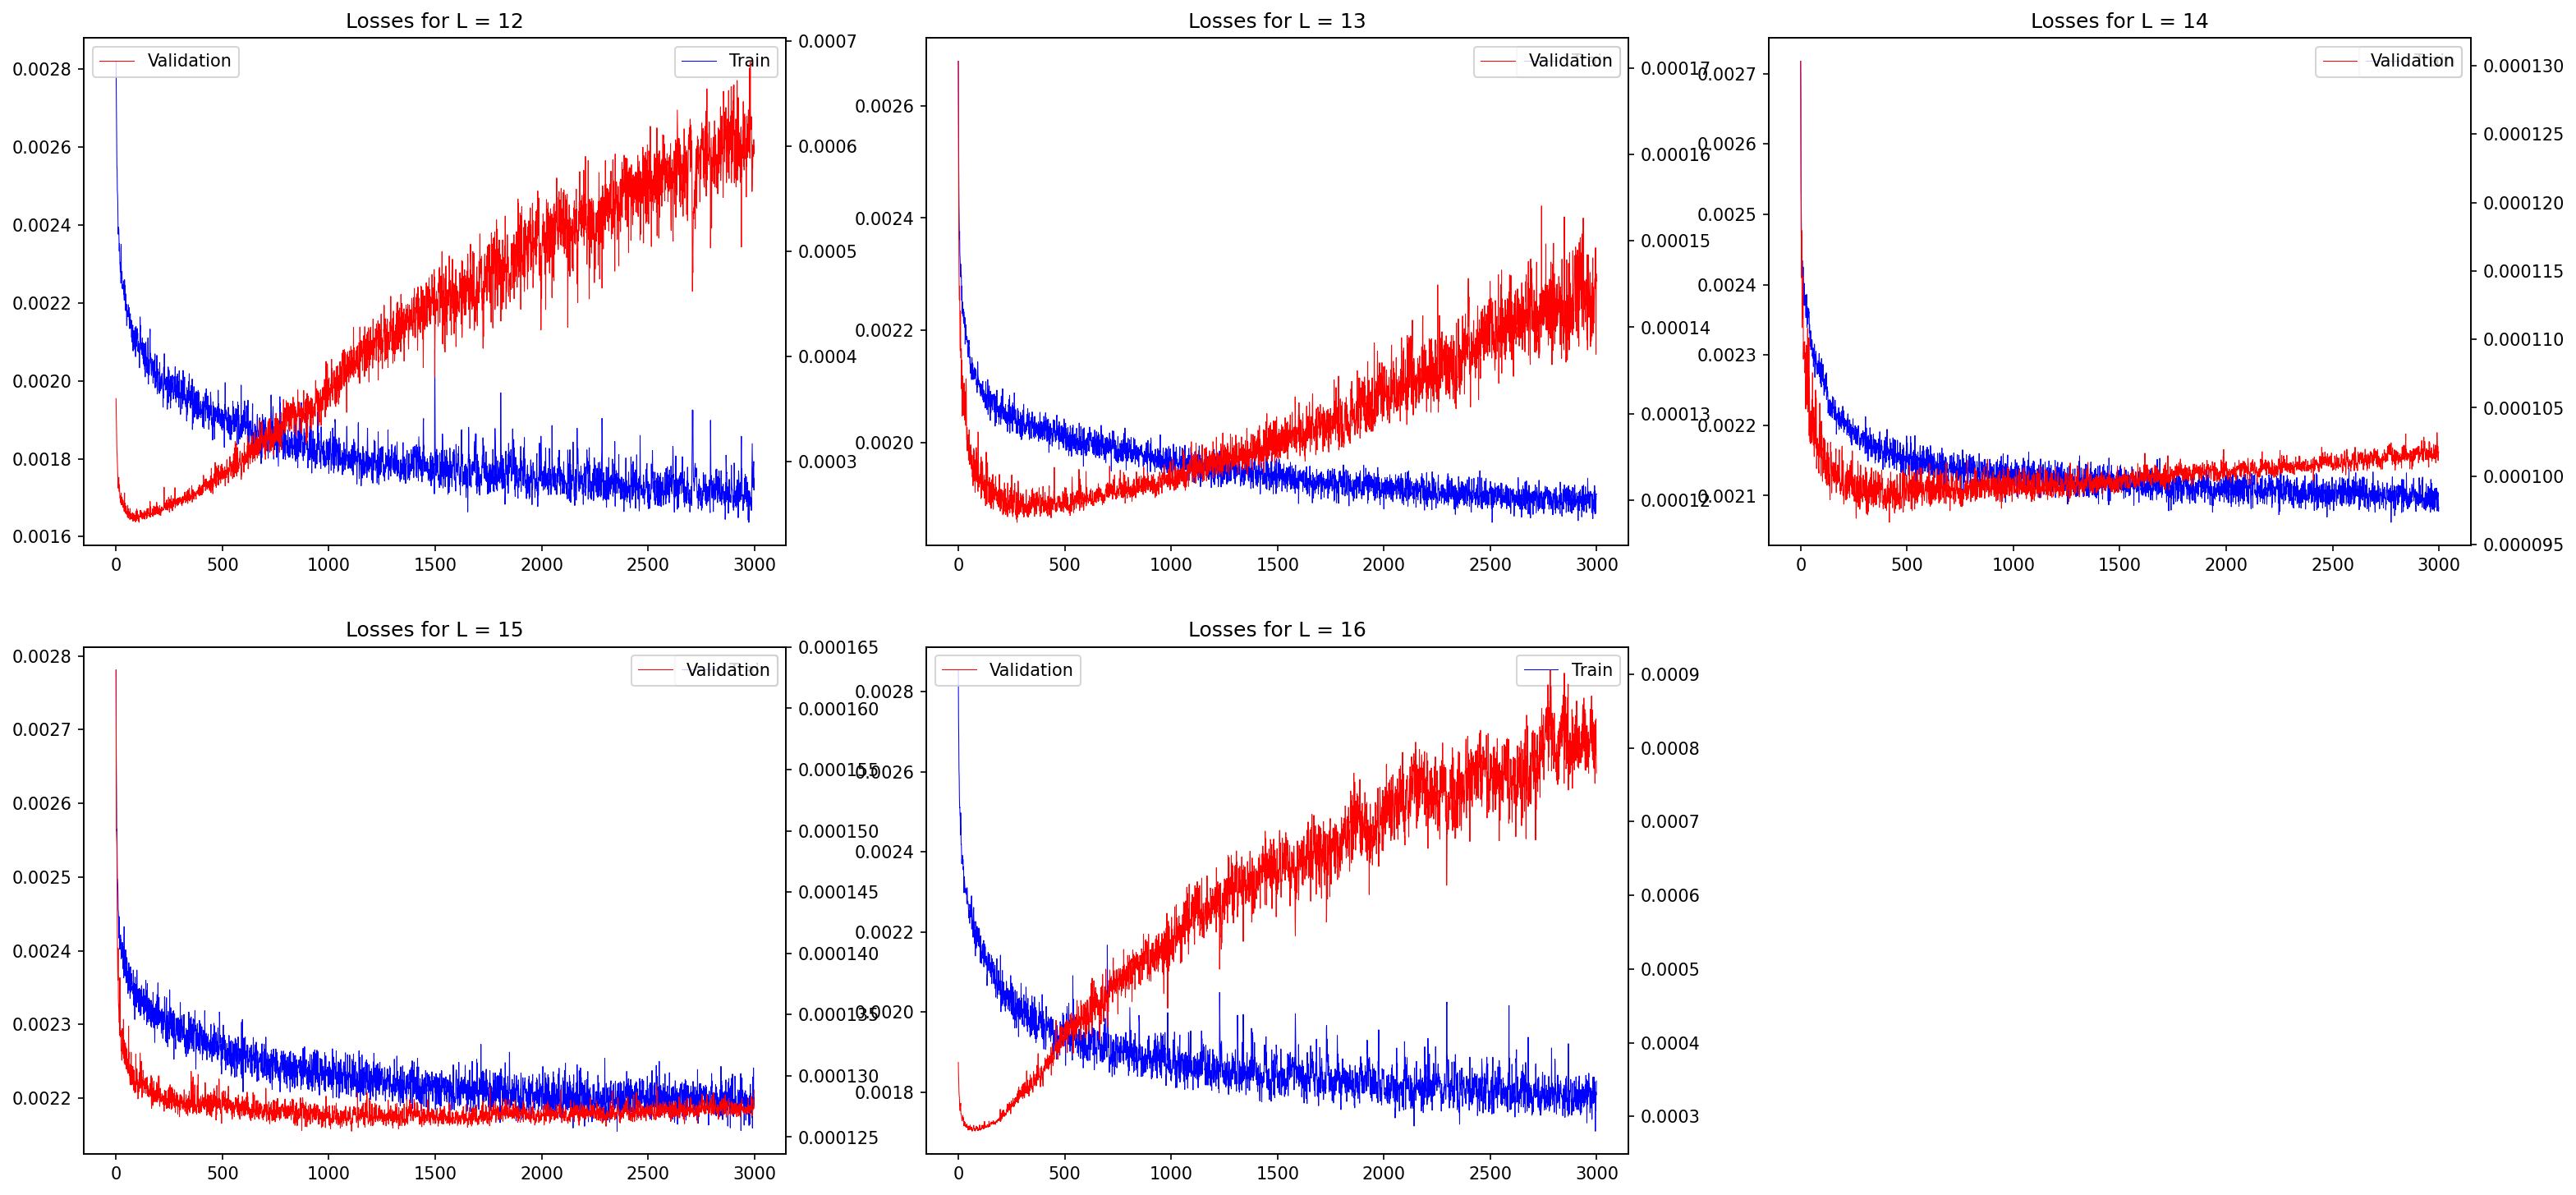

In [22]:
f, a = plt.subplots(2,3, figsize=(25,12))

for index,ll in enumerate(range(12,17)):
    a1 = a.ravel()[index]
    a2 = a1.twinx()
    a1.plot(train_loss_dict[ll], 'b-', lw =0.5, label='Train')#, ax=a)
    a2.plot(val_loss_dict[ll], 'r-', lw = 0.5, label='Validation')#,ax=a)
    a1.legend(loc='best')
    a2.legend(loc='best')
    a1.set_title('Losses for L = {}'.format(ll))
f.delaxes(a.ravel()[-1])
plt.savefig('fig.jpg')

In [87]:
from datetime import datetime
from src.train_eval import *
TRAIN_FEATURES, TRAIN_LABELS, model_dict = reload()

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
nb_epochs = 1000
criterion = nn.CrossEntropyLoss()
ratio = 1/4
mini_batch_size = 250

acc_dict = {}
AUC_dict = {}

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)

for l in range(12,17):
    #splits:
    indices = torch.randperm(TRAIN_FEATURES[l].size(0))
    
    z = math.ceil((1-ratio)* TRAIN_FEATURES[l].size(0))
    
    model_dict[l].to(device)

    data_temp = TRAIN_FEATURES[l].detach().clone().to(device)
    labels_temp = TRAIN_LABELS[l].detach().clone().to(device)
    
    train_data, train_target, eval_data, eval_target = shuffle_split(data_temp,
                                                                     labels_temp,
                                                                     ratio)
    
    optimizer = optim.Adam(model_dict[l].parameters(), lr = 0.00125)
    print(model_dict[l].dummy_param.device, train_data.device, eval_target.device)
    accs = []
    AUCs = []
    print("\n######L=",l)
    print("TOTAL OF {} samples, {} in train and {} in val.".format(data_temp.size(0),
                                                                   train_data.size(0),
                                                                   eval_data.size(0)))

    for e in range(nb_epochs):

        _ = train_model(model_dict[l], criterion, optimizer, train_data, train_target, e, mini_batch_size)
        _, acc, auc = eval_model(model_dict[l], criterion, eval_data, eval_target)
        accs.append(acc)
        AUCs.append(auc)
        if e%100==0:print("\nEPOCHS =",e,"\nAccuracy:",acc,"\nAUC:",auc)
            
    acc_dict[l]=accs
    AUC_dict[l]=AUCs
    
    #saveplot(l)
    model_dict[l].to('cpu')
    del TRAIN_FEATURES[l]
    del TRAIN_LABELS[l]
    
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

TRAIN TENSORS torch.Size([7379, 1, 15, 12]) cpu
LABELS torch.Size([7379]) cpu
cpu
Start Time = 22:41:03
cuda:0 cuda:0 cuda:0

######L= 12
TOTAL OF 7379 samples, 5535 in train and 1844 in val.

EPOCHS = 0 
Accuracy: 0.6095444685466378 
AUC: 0.6405829873467774

EPOCHS = 100 
Accuracy: 0.7754880694143167 
AUC: 0.8529915480427046
cuda:0 cuda:0 cuda:0

######L= 13
TOTAL OF 14953 samples, 11215 in train and 3738 in val.

EPOCHS = 0 
Accuracy: 0.6730872124130551 
AUC: 0.6793683787447959

EPOCHS = 100 
Accuracy: 0.7915997859818085 
AUC: 0.8633921822697332
cuda:0 cuda:0 cuda:0

######L= 14
TOTAL OF 19451 samples, 14589 in train and 4862 in val.

EPOCHS = 0 
Accuracy: 0.6240230357877417 
AUC: 0.6916327753007852

EPOCHS = 100 
Accuracy: 0.7622377622377622 
AUC: 0.8270646927815899
cuda:0 cuda:0 cuda:0

######L= 15
TOTAL OF 16393 samples, 12295 in train and 4098 in val.

EPOCHS = 0 
Accuracy: 0.6325036603221084 
AUC: 0.7242502675784243

EPOCHS = 100 
Accuracy: 0.764763299170327 
AUC: 0.839242020008

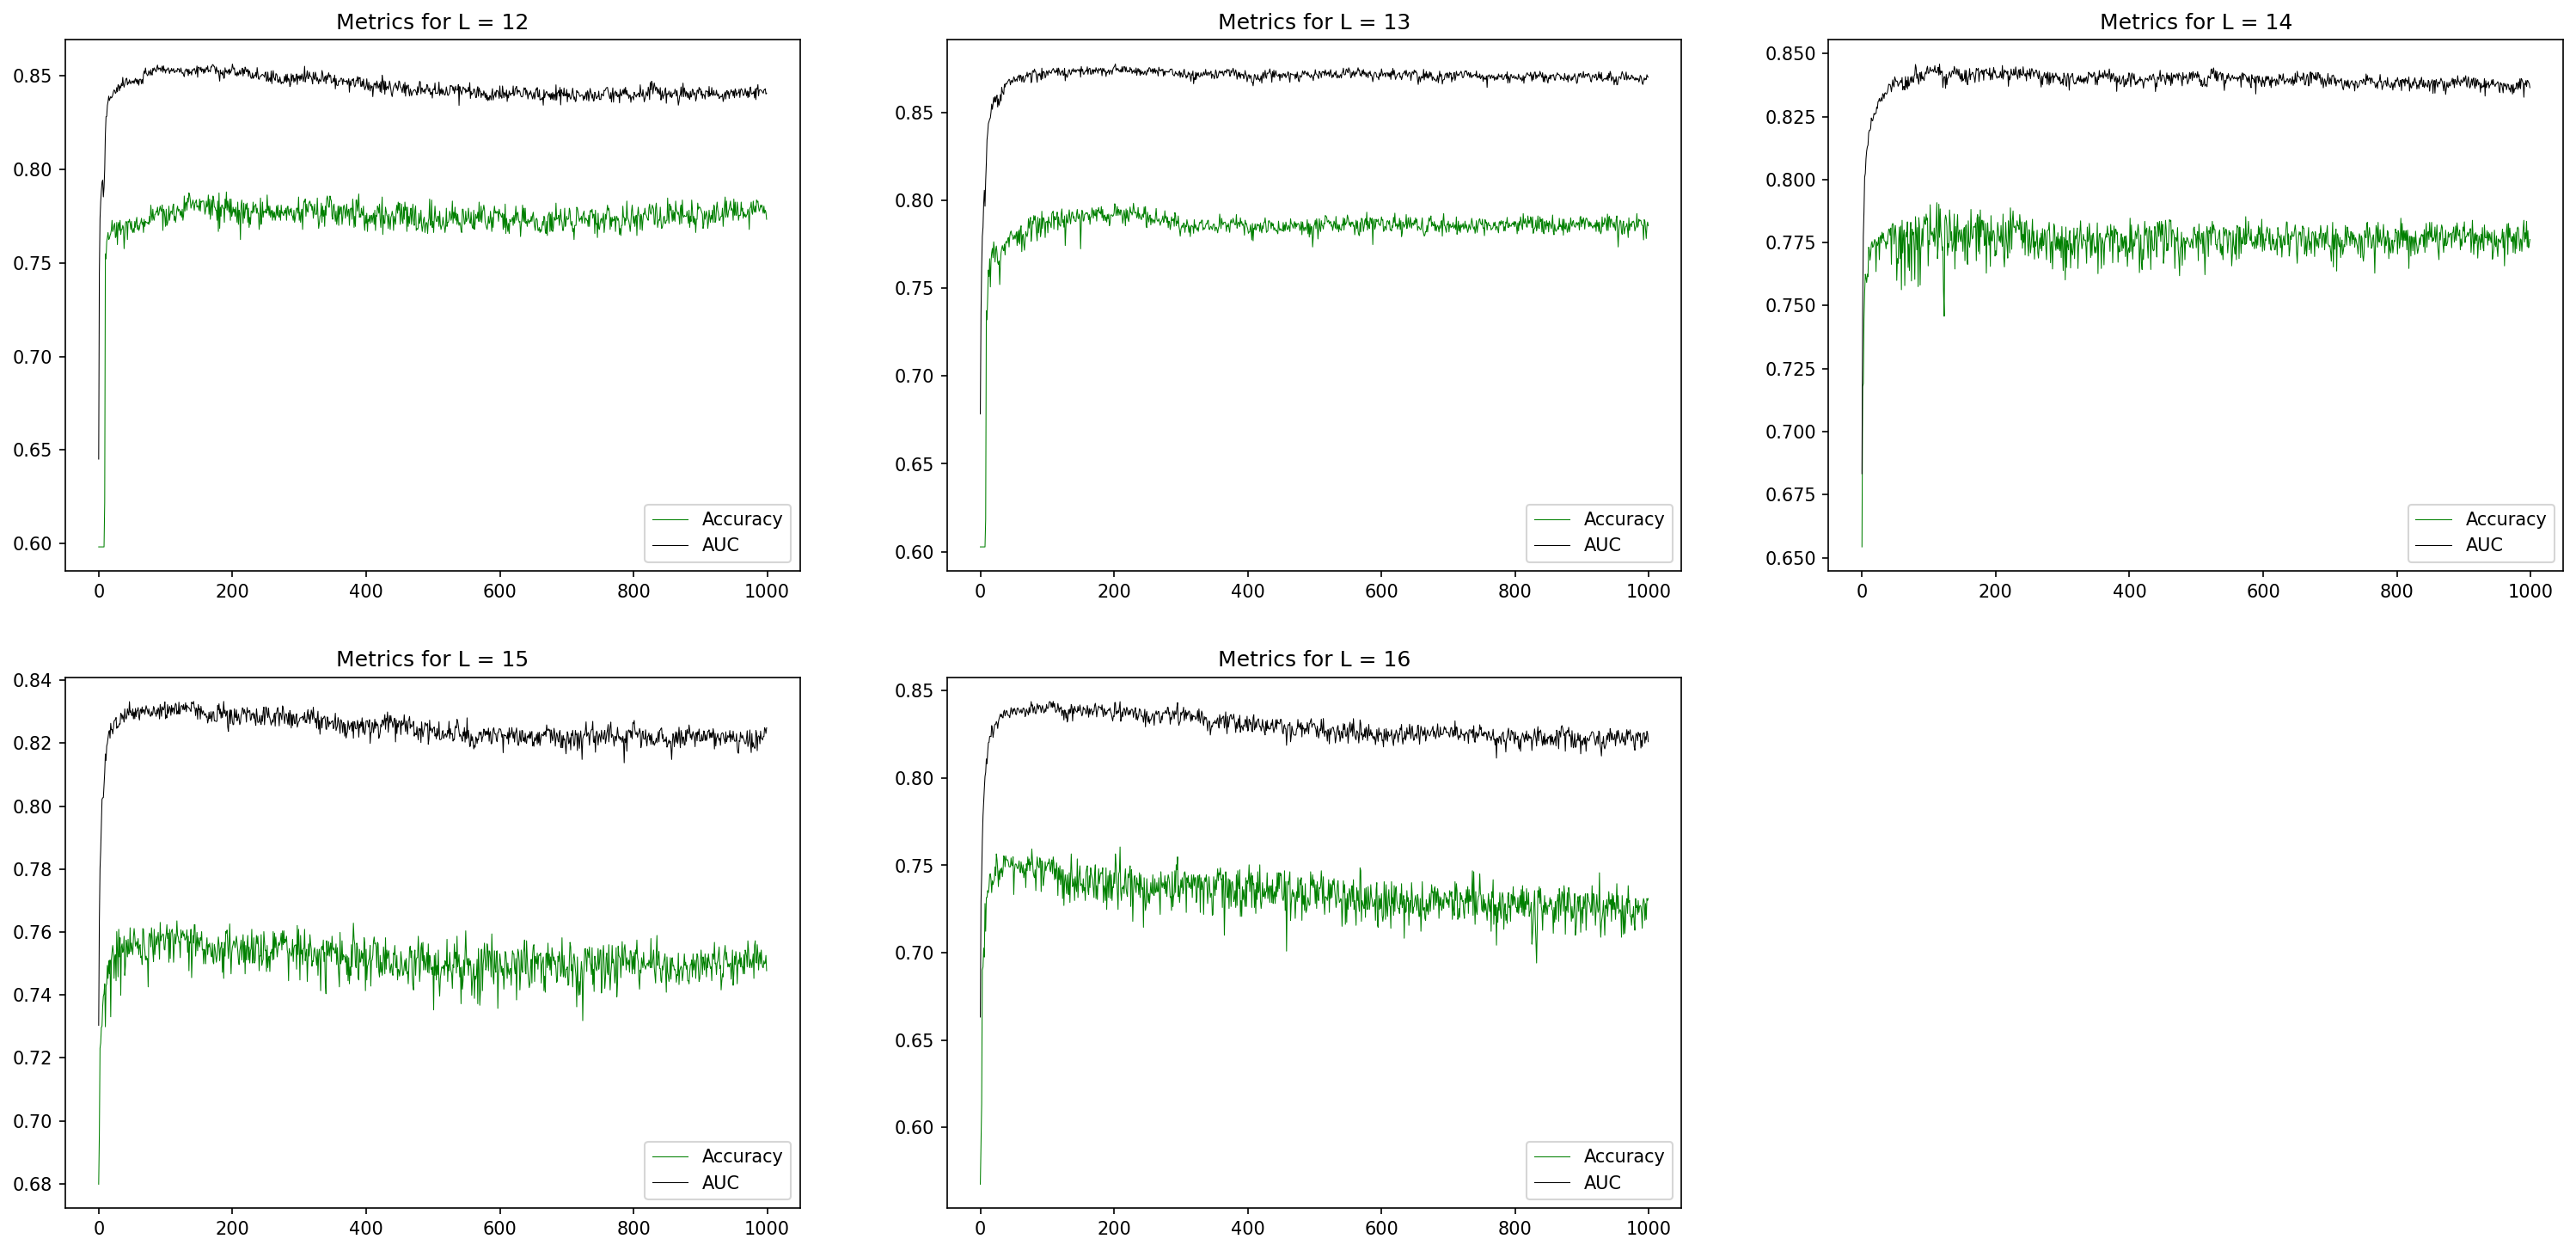

In [10]:
f, a = plt.subplots(2,3, figsize=(25,12))

for index,ll in enumerate(range(12,17)):
    a1 = a.ravel()[index]
    #a2 = a1.twinx()
    a1.plot(acc_dict[ll], 'g-', lw =0.5, label='Accuracy')#, ax=a)
    a1.plot(AUC_dict[ll], 'k-', lw = 0.5, label='AUC')#,ax=a)
    a1.legend(loc='best')
    a1.set_title('Metrics for L = {}'.format(ll))
f.delaxes(a.ravel()[-1])
plt.savefig('acc_fig.jpg')

In [115]:
def get_curve(model, data, labels):
    """
    using sklearn.metrics.roc_curve
    """
    model.eval()
    #one_hot = one_hot_labels(labels).cpu() # from preprocessing.py
    
    #Full test_set in case of unbalanced data
    #Logits = raw for loss, predictions = argmax(logit), probs = softmax(logit)
    logits, _, probs = model(data)
    curve = roc_curve(labels.detach().cpu(), probs.detach().cpu()[:,1], pos_label=1)
    return curve
    
def shuffle(features, target):
    #shuffling
    indices = torch.randperm(features.size(0))
    data = features[indices]
    labels = target[indices]
    return data, labels


In [118]:
#Reloading training set
TRAIN_FEATURES, TRAIN_LABELS, model_dict = reload()
#loading test sets as well
test_normal = read_seq(TRAINDIR+files[1])
test_tumor = read_seq(TRAINDIR+files[3])
test_features, test_label = generate_features_labels(test_tumor, test_normal, None)#device)
curve_dict = {}
aucs_dict = {}

nb_epochs = 200
mini_batch_size = 200
#Retraining from scratch
for ls in range(12,17):
    model_dict[ls].to(device)
    train_data = TRAIN_FEATURES[ls].detach().clone().to(device)
    train_target = TRAIN_LABELS[ls].detach().clone().to(device)
    optimizer = optim.Adam(model_dict[ls].parameters(), lr = 0.00125)
    criterion = nn.CrossEntropyLoss()
    for e in range(nb_epochs):        
        _ = train_model(model_dict[ls], criterion, optimizer, train_data, train_target, e, mini_batch_size)

    data, labels = shuffle(test_features[ls], test_label[ls])
    data = data.to(device)
    labels = labels.to(device)
    print(data.device)
    _,_, auc= eval_model(model_dict[ls], criterion, data, labels)
    aucs_dict[ls]= auc
    curve_dict[ls] = get_curve(model_dict[ls], data, labels)

TRAIN TENSORS torch.Size([7379, 1, 15, 12]) cpu
LABELS torch.Size([7379]) cpu
cpu
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0


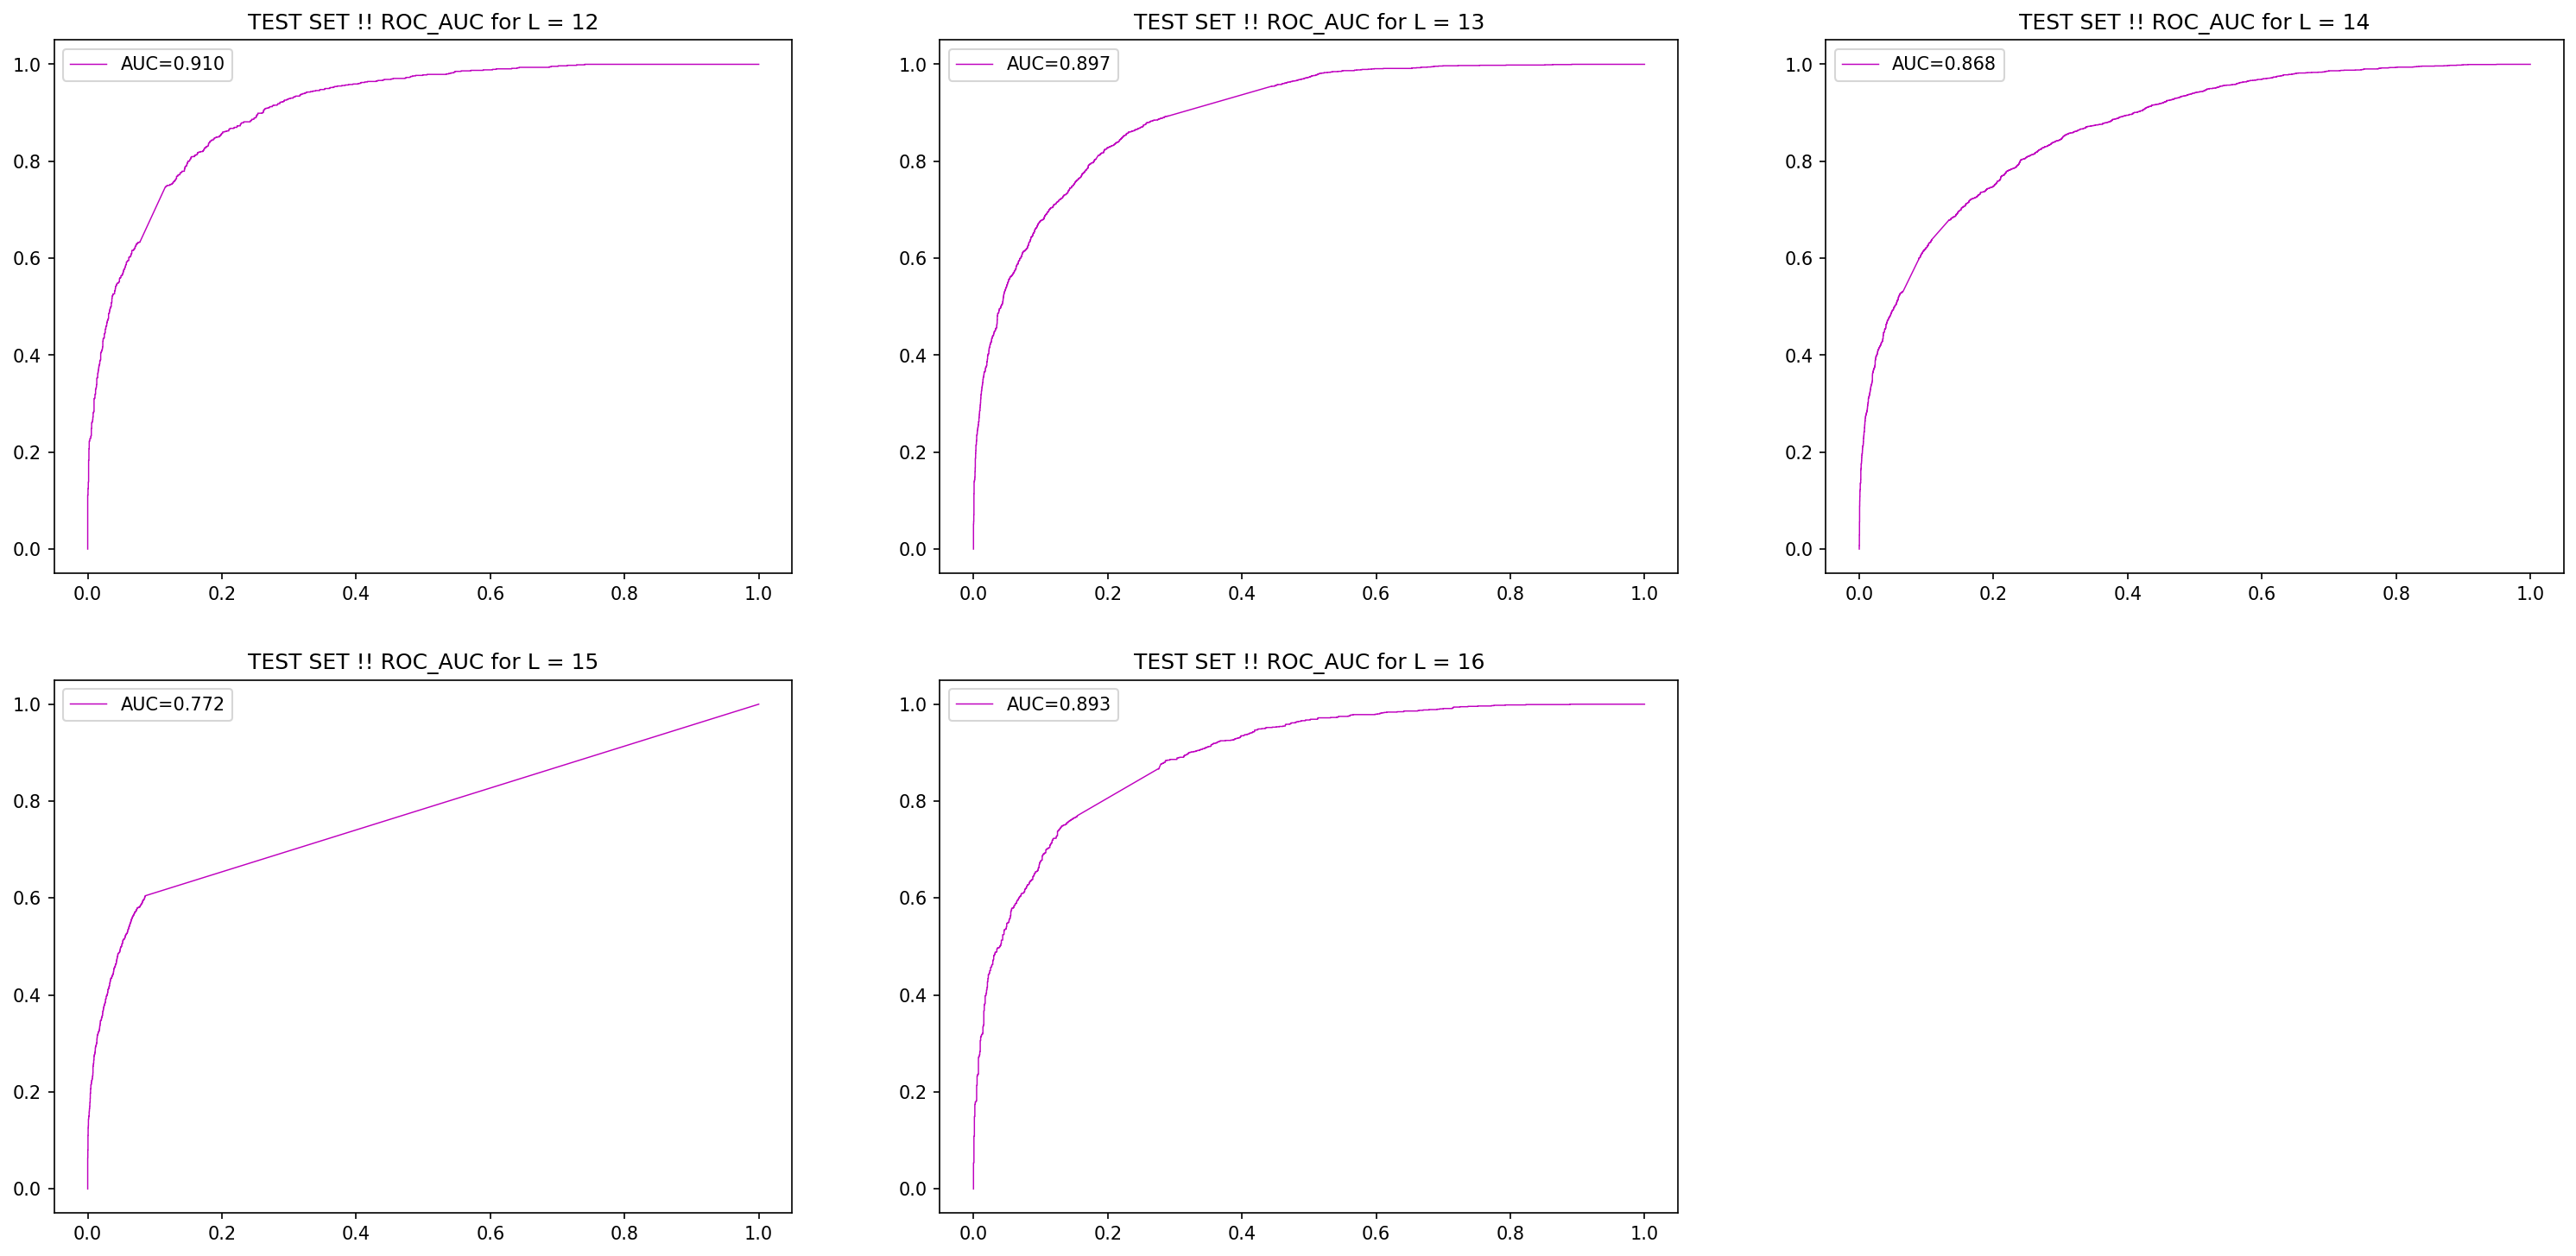

In [119]:
f, a = plt.subplots(2,3, figsize=(25,12))

for index,ll in enumerate(range(12,17)):
    a1 = a.ravel()[index]
    #a2 = a1.twinx()
    a1.plot(curve_dict[ll][0],curve_dict[ll][1], 'm-', lw =0.7, label='AUC={:.3f}'.format(aucs_dict[ll]))
    #a1.plot(AUC_dict[ll], 'k-', lw = 0.5, label='AUC')#,ax=a)
    a1.legend(loc='best')
    a1.set_title('TEST SET !! ROC_AUC for L = {}'.format(ll))
f.delaxes(a.ravel()[-1])
plt.savefig('test_AUC.jpg')